In [201]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *
import helper_methods_for_aggregate_data_analysis as helper
from model_experiments import *
from model_results import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as tick
from collections import Counter 
import datetime
import os
import pickle

pd.set_option('display.max_colwidth', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data summaries

## Washington DC plots (Figure 2)

In [6]:
# this will be x-axis for every plot
all_dates = helper.list_datetimes_in_range(datetime.datetime(2020, 3, 1), datetime.datetime(2021, 1, 9))
time_periods = [(datetime.datetime(2020, 3, 15), datetime.datetime(2020, 5, 14)),
                (datetime.datetime(2020, 11, 1), datetime.datetime(2020, 12, 31))]
for start, end in time_periods:
    dates_in_period = helper.list_datetimes_in_range(start, end)
    print('%d days' % len(dates_in_period))
msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'

61 days
61 days


In [7]:
hourly_visits_per_poi, poi_ids, visits_hours = helper.load_all_poi_visits_for_msa(msa_name, return_ids=True)
visits_dates = [dt for dt in visits_hours if dt.hour == 0]
assert len(visits_dates) == int(len(visits_hours) / 24)
daily_visits = np.zeros(len(visits_dates))
for i in np.arange(len(visits_dates)):
    day_start = i * 24
    day_end = day_start + 24
    daily_visits[i] = np.sum(hourly_visits_per_poi[:, day_start:day_end])
smoothed_daily_visits = apply_smoothing(daily_visits, before=7, after=7)

FileNotFoundError: [Errno 2] No such file or directory: '/media/gpu/easystore/all_aggregate_data/ipf_output/Washington_Arlington_Alexandria_DC_VA_MD_WV/2020-11-30_to_2021-04-05_poi_hourly_visits.npy'

In [4]:
mask_df = helper.load_mask_use_data('VA')
mask_dates = [datetime.datetime.strptime(s, '%Y-%m-%d') for s in mask_df.date]
daily_mask_use = mask_df['mask use'].values / 100

In [5]:
nyt_outcomes, _, _, _, _ = get_variables_for_evaluating_msa_model(msa_name)
real_dates, real_cases, real_deaths = get_datetimes_and_totals_from_nyt_outcomes(nyt_outcomes)
real_cases = get_daily_from_cumulative(real_cases)
smoothed_cases = apply_smoothing(real_cases, before=7, after=7)

In [6]:
def get_timeseries_for_corresponding_dates(orig_ts, orig_dates, dates_to_match):
    assert len(orig_ts) == len(orig_dates)
    ts = []
    for d in dates_to_match:
        if d in orig_dates:
            ts.append(orig_ts[orig_dates.index(d)])
        else:
            ts.append(np.nan)
    return ts

Text(0.5, 0, 'Month')

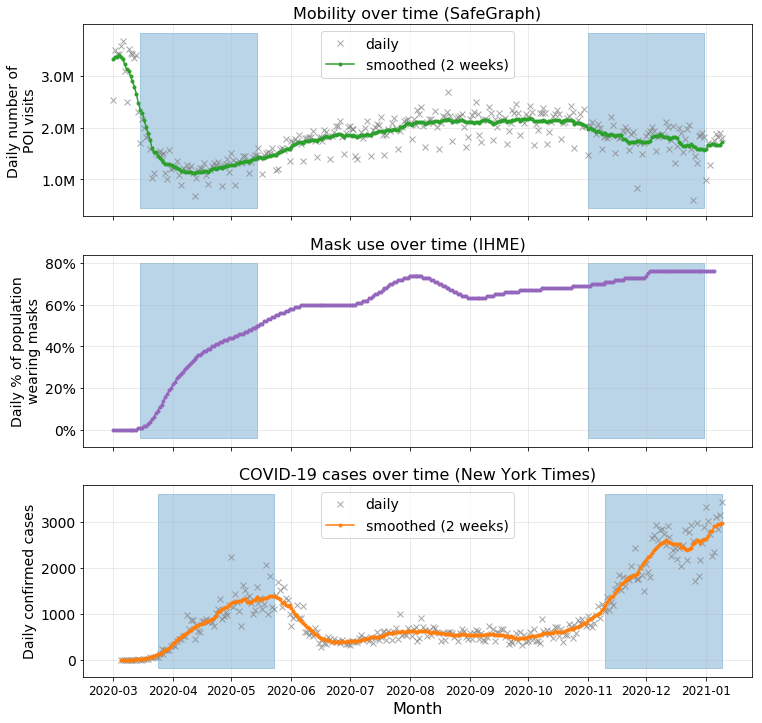

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

ax = axes[0]
ax.set_title('Mobility over time (SafeGraph)', fontsize=16)
ts = get_timeseries_for_corresponding_dates(daily_visits, visits_dates, all_dates)
ax.plot_date(all_dates, ts, marker='x', alpha=0.7, color='grey', label='daily')
ts = get_timeseries_for_corresponding_dates(smoothed_daily_visits, visits_dates, all_dates)
ax.plot_date(all_dates, ts, linestyle='-', marker='.', color='tab:green', label='smoothed (2 weeks)')
ymin, ymax = ax.get_ylim()
for start, end in time_periods:
    ax.fill_betweenx([ymin, ymax], [start, start], [end, end], color='tab:blue', alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_ylabel('Daily number of\nPOI visits', fontsize=14)
ax.legend(loc='upper center', fontsize=14)

ax = axes[1]
ax.set_title('Mask use over time (IHME)', fontsize=16)
ts = get_timeseries_for_corresponding_dates(daily_mask_use, mask_dates, all_dates)
ax.plot_date(all_dates, ts, linestyle='-', marker='.', color='tab:purple')
ymin, ymax = ax.get_ylim()
for start, end in time_periods:
    ax.fill_betweenx([ymin, ymax], [start, start], [end, end], color='tab:blue', alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_decimal_as_percent))
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_ylabel('Daily % of population\nwearing masks', fontsize=14)

ax = axes[2]
ax.set_title('COVID-19 cases over time (New York Times)', fontsize=16)
ts = get_timeseries_for_corresponding_dates(real_cases, real_dates, all_dates)
ax.plot_date(all_dates, ts, marker='x', alpha=0.7, color='grey', label='daily')
ts = get_timeseries_for_corresponding_dates(smoothed_cases, real_dates, all_dates)
ax.plot_date(all_dates, ts, linestyle='-', marker='.', color='tab:orange', label='smoothed (2 weeks)')
ymin, ymax = ax.get_ylim()
for start, end in time_periods:
    start_lagged = start + datetime.timedelta(days=DETECTION_LAG)
    end_lagged = end + datetime.timedelta(days=DETECTION_LAG)
    ax.fill_betweenx([ymin, ymax], [start_lagged, start_lagged], [end_lagged, end_lagged], color='tab:blue', alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=12)
ax.grid(alpha=0.3)
ax.set_ylabel('Daily confirmed cases', fontsize=14)
ax.legend(loc='upper center', fontsize=14)
ax.set_xlabel('Month', fontsize=16)

## POI-CBG network stats (Table 1)

In [8]:
msas = ['Washington_Arlington_Alexandria_DC_VA_MD_WV', 'Richmond_VA', 'Virginia_Beach_Norfolk_Newport_News_VA_NC']
min_datetime = datetime.datetime(2020, 11, 1, 0)
max_datetime = datetime.datetime(2020, 12, 31, 23)
msa2ipf = {}
for msa_name in msas:
    ipf_out, poi_ids, cbg_ids = helper.load_ipf_output_for_hours(msa_name, min_datetime, max_datetime, return_ids=True)
    msa2ipf[msa_name] = (ipf_out, poi_ids, cbg_ids)

Loading IPF output for 1464 hours
Finished loading IPF output in 181.33s [0.12s per hour]
Loading IPF output for 1464 hours
Finished loading IPF output in 45.79s [0.03s per hour]
Loading IPF output for 1464 hours
Finished loading IPF output in 68.65s [0.05s per hour]


In [9]:
rows = []
for msa_name in msa2ipf:
    ipf_out, poi_ids, cbg_ids = msa2ipf[msa_name]
    total = 0
    for m in ipf_out:
        nonzero = np.sum(m > 0)
        total += nonzero
    print('%s: num POIs = %d, num CBGs = %d, num edges = %d' % (msa_name, len(poi_ids), len(cbg_ids), total))
    rows.append({'msa':msa_name, 'pois':len(poi_ids), 'cbgs':len(cbg_ids), 'edges':total})
columns = list(rows[0].keys())
df = pd.DataFrame(rows, columns=columns)

Washington_Arlington_Alexandria_DC_VA_MD_WV: num POIs = 40467, num CBGs = 4904, num edges = 2095359467
Richmond_VA: num POIs = 9917, num CBGs = 1098, num edges = 516647719
Virginia_Beach_Norfolk_Newport_News_VA_NC: num POIs = 13360, num CBGs = 1607, num edges = 786389095


In [10]:
acs_d = helper.load_and_reconcile_multiple_acs_data()
cbgs_to_census_pops = dict(zip(acs_d['census_block_group'].values,
                               acs_d['total_cbg_population_2018_1YR'].values))  # use most recent population data
total_pop_sizes = []
for msa_name in df.msa.values:
    cbgs = msa2ipf[msa_name][2]
    pop_sizes = [cbgs_to_census_pops[c] for c in cbgs]
    total_pop_sizes.append(np.sum(pop_sizes))
df['pop_size'] = total_pop_sizes
df

220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read


,msa,pois,cbgs,edges,pop_size
0,Washington_Arlington_Alexandria_DC_VA_MD_WV,40467,4904,2095359467,9200384
1,Richmond_VA,9917,1098,516647719,2048200
2,Virginia_Beach_Norfolk_Newport_News_VA_NC,13360,1607,786389095,2854769


# 2. Model fit

In [8]:
def plot_model_fit_for_msa(best_models, msa_name, ax, min_datetime, max_datetime,
                           mode='cases', train_test_partition=None, additional_kwargs=None):
    msa_best_models = best_models[best_models.MSA_name == msa_name]
    nyt_outcomes, _, _, _, _ = get_variables_for_evaluating_msa_model(msa_name)  
    lag = DEATH_LAG if mode == 'deaths' else DETECTION_LAG
    other_plotting_kwargs =  {
            'plot_log':False, 
            'plot_legend':True,
            'plot_errorbars':True,
            'xticks':[min_datetime + datetime.timedelta(days=lag),
                      max_datetime + datetime.timedelta(days=lag)],                                                                             
            'x_range':[min_datetime + datetime.timedelta(days=lag),
                       max_datetime + datetime.timedelta(days=lag)],        
            'plot_daily_not_cumulative':True,
            'model_line_label': 'Model predictions',
            'true_line_label': 'Reported %s' % mode,
            'title_fontsize':20,
            'marker_size':5,
            'real_data_color':'tab:orange',
            'model_color':'tab:blue',
            'plot_mode':mode,
    }
    if additional_kwargs is not None:
        for k,v in additional_kwargs.items():
            other_plotting_kwargs[k] = v
    score_dict = plot_best_models_fit_for_msa(msa_best_models, msa_name, ax, key_to_sort_by=None, train_test_partition=train_test_partition, 
                                 plotting_kwargs=other_plotting_kwargs, use_given_df=True)
    ax.grid(alpha=0.1)
    ax.set_ylabel('Daily confirmed %s' % mode, fontsize=20)
    return score_dict

def compute_rmses(pred_dates, pred_data, real_dates, real_data, train_test_partition=None, normalized=False):
    assert pred_data.shape[1] == len(pred_dates)
    assert len(real_data) == len(real_dates)
    overlap_dates = sorted(set(pred_dates).intersection(set(real_dates)))
    y_true = []
    y_pred = []
    for dt in overlap_dates:
        if train_test_partition is None or dt >= train_test_partition:
            pred_index = pred_dates.index(dt)
            pred_vec = pred_data[:, pred_index]
            y_pred.append(pred_vec)
            real_index = real_dates.index(dt)
            observed = real_data[real_index]
            y_true.append(observed)
    y_pred = np.array(y_pred).T  # num seeds x dates 
    y_true = np.array(y_true)
    assert y_pred.shape[1] == len(y_true)
    
    mean_rmse_over_seeds = RMSE(y_true, y_pred)
    rmse_of_mean = RMSE(y_true, np.mean(y_pred, axis=0))
    if normalized:  # normalize by mean of y_true so that we can compare across time periods / MSAs 
        mean_rmse_over_seeds = mean_rmse_over_seeds / np.mean(y_true)
        rmse_of_mean = rmse_of_mean / np.mean(y_true)
    return mean_rmse_over_seeds, rmse_of_mean

## Washington DC, first wave (Table 2, Figure 4, Table A2)

In [150]:
msa_name = 'Columbia_SC'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 12, 20)
max_datetime = datetime.datetime(2021, 1, 30)

Loading models with timestrings between 2021_11_28_13_16203770 and 2021_11_28_13_22203770
4321 files in directory /media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs
Found 27 fitted models for Columbia_SC
Time to load and score all models: 0.037s -> 0.001s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.000
Columbia_SC: 1 within loss tol -> keeping 1
                                                                                              home_beta  poi_psi
11  [0.014499999999999999, 0.014364062499999998, 0.014228125, 0.014092187499999999, 0.01395625, 0.01...      9.0
0.0090625 0.014499999999999999
Plotting predictions from 1 models
Applying time-varying CDR to visualization


/media/gpu/easystore/covid-mobility-tool/model_experiments.py:2811: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(real_dates, real_data, marker='x', c='grey', alpha=0.8,


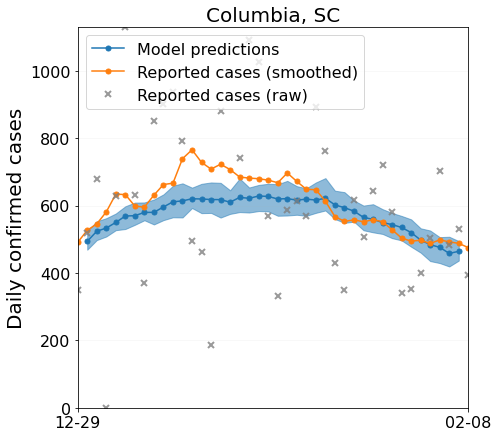

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
11,2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13816183763756304, 0.1364788059764155, 0.13883358086371483, 0.13817758161942598, 0.1392423995...",2020-12-29,2021-02-07,"[[43064.4, 43538.4, 44038.2, 44530.799999999996, 45055.799999999996, 45566.4, 46101.0, 46650.0, ...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",8192.084666,6.718175e+07,250.81496,62930.2495,238.925536,61.976782,0.264619,0.264619,0.264619,0.264619,0.264619,1833.970792,59709.263864,1833.970792,59709.263864,...,3.838406,0.000023,0.000013,0.000043,"[0.014499999999999999, 0.014364062499999998, 0.014228125, 0.014092187499999999, 0.01395625, 0.01...",9.0,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45039, 45063, 45017, 45079, 45081, 45055]",None,None,None,Columbia_SC,0.0145,0.009062,0.625


In [334]:
# full model

import matplotlib.pyplot as plt



max_timestring = '2021_11_28_02_44_203770'  # group 2
min_timestring = '2021_11_27_23_34_000000'

max_timestring = '2021_11_27_23_35_000000' # group 1
min_timestring = '2021_11_27_19_45_000000'

max_timestring = '2021_11_28_13_00_203770'  # group 3   # 931 , 
min_timestring = '2021_11_28_09_10_203770'    # 931 2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search

# max_timestring = '2021_11_28_13_15_203770'  # group 4  bad, not use 
# min_timestring = '2021_11_28_13_05_203770'    

# max_timestring = '2021_11_28_13_44_203770'  # group 5  GOOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
# min_timestring = '2021_11_28_13_23_203770' 

max_timestring = '2021_11_28_13_22203770'  # group 4.5 OOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
min_timestring = '2021_11_28_13_16203770' 

expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
# assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
gridsearch_df['start_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[0])
gridsearch_df['end_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[-1])
gridsearch_df['beta_ratio'] = gridsearch_df.end_beta.values / gridsearch_df.start_beta.values

best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.0, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())


fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()
best_models_df

In [ ]:
# Good! 


print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())


fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()
best_models_df

                                                                                               home_beta    poi_psi
931  [0.014666666666666666, 0.014483333333333332, 0.0143, 0.014116666666666666, 0.013933333333333332,...  11.785714
0.007333333333333333 0.014666666666666666
Plotting predictions from 1 models
Applying time-varying CDR to visualization


/media/gpu/easystore/covid-mobility-tool/model_experiments.py:2811: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(real_dates, real_data, marker='x', c='grey', alpha=0.8,


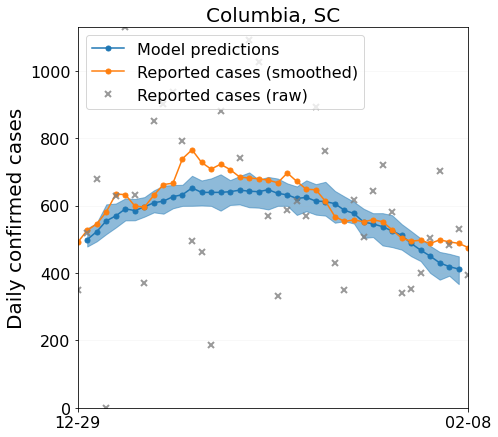

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
931,2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13771313415446945, 0.13493064775989377, 0.13778188287527093, 0.13634655652876687, 0.136392738...",2020-12-29,2021-02-07,"[[43057.2, 43521.6, 44023.2, 44526.6, 45083.4, 45648.6, 46227.6, 46795.799999999996, 47398.2, 47...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7952.232871,6.331378e+07,248.782602,61922.315,237.240052,53.53417,0.272384,0.272384,0.272384,0.272384,0.272384,1796.159902,58513.703102,1796.159902,58513.703102,...,3.836764,0.000023,0.000013,0.000043,"[0.014666666666666666, 0.014483333333333332, 0.0143, 0.014116666666666666, 0.013933333333333332,...",11.785714,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45081, 45017, 45063, 45055, 45039, 45079]",None,None,None,Columbia_SC,0.014667,0.007333,0.5


In [260]:
# Good! 

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())

fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()

best_models_df

                                                                                              home_beta    poi_psi
20  [0.015333333333333332, 0.01510972222222222, 0.01488611111111111, 0.014662499999999998, 0.0144388...  11.666667
0.006388888888888888 0.015333333333333332
Plotting predictions from 1 models
Applying time-varying CDR to visualization


/media/gpu/easystore/covid-mobility-tool/model_experiments.py:2811: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(real_dates, real_data, marker='x', c='grey', alpha=0.8,


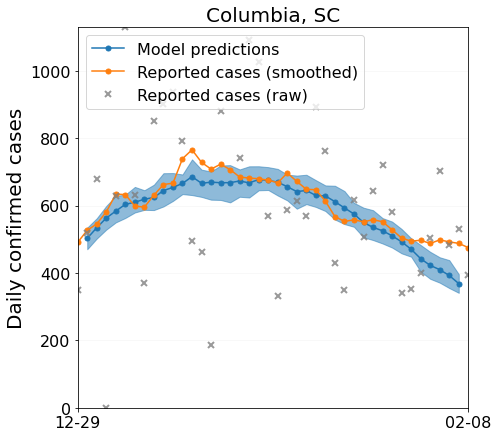

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
20,2021_11_28_13_30_17_509206_normal_grid_search_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13768269578953446, 0.13730169142845147, 0.13819385040068433, 0.13711538764307343, 0.136989435...",2020-12-29,2021-02-07,"[[43064.4, 43529.4, 44026.2, 44531.4, 45081.0, 45676.799999999996, 46252.2, 46811.4, 47425.2, 48...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7591.910768,5.768706e+07,245.257384,60172.0213,235.526693,48.662176,0.278464,0.278464,0.278464,0.278464,0.278464,1681.522608,56976.163377,1681.522608,56976.163377,...,3.816624,0.000023,0.000013,0.000043,"[0.015333333333333332, 0.01510972222222222, 0.01488611111111111, 0.014662499999999998, 0.0144388...",11.666667,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45017, 45079, 45055, 45063, 45081, 45039]",None,None,None,Columbia_SC,0.015333,0.006389,0.416667


In [304]:
# Good! Group 5
max_timestring = '2021_11_28_13_44_203770'  # group 5  GOOD:  # 2021_11_28_13_18_45_911113_normal_grid_search_normal_grid_search
min_timestring = '2021_11_28_13_23_203770' 

# Loading models with timestrings between 2021_11_28_13_15_203770 and 2021_11_28_13_25_203770

print(best_models_df[['home_beta', 'poi_psi']])
print(best_models_df['home_beta'].iloc[0].min(), best_models_df['home_beta'].iloc[0].max())

fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
plt.show()

best_models_df

In [223]:
# best_models_df.head(5)
print(best_models_df[['home_beta', 'poi_psi']])

                                                                                               home_beta    poi_psi
296  [0.013388888888888888, 0.013221527777777776, 0.013054166666666665, 0.012886805555555554, 0.01271...  16.428571
413  [0.013388888888888888, 0.013305208333333332, 0.013221527777777776, 0.013137847222222221, 0.01305...  10.000000


In [242]:
bt = best_models_df['home_beta'].iloc[0]
bt.min()

0.011

In [246]:
best_models_df

,timestring,data_kwargs,model_kwargs,results,experiment_to_run,final infected fraction,loss_dict_eval_start_time_cases,loss_dict_eval_end_time_cases,loss_dict_cumulative_predicted_cases,loss_dict_cumulative_true_cases,loss_dict_cumulative_cases_RMSE,loss_dict_cumulative_cases_MSE,loss_dict_daily_cases_RMSE,loss_dict_daily_cases_MSE,loss_dict_daily_cases_RMSE_time_varying_cdr,loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr,loss_dict_daily_cases_MRE_thres-1_sum,loss_dict_daily_cases_MRE_thres-10_sum,loss_dict_daily_cases_MRE_thres-20_sum,loss_dict_daily_cases_MRE_thres-50_sum,loss_dict_daily_cases_MRE_thres-100_sum,loss_dict_daily_cases_poisson_NLL_thres-1_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-1_sum,loss_dict_daily_cases_poisson_NLL_thres-10_logsumexp,loss_dict_daily_cases_poisson_NLL_thres-10_sum,...,agg_county_loss_dict_max_daily_deaths_RMSE,agg_county_loss_dict_unweighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_weighted_avg_daily_deaths_per_capita_RMSE,agg_county_loss_dict_max_daily_deaths_per_capita_RMSE,home_beta,poi_psi,p_sick_at_t0,inter_cbg_gamma,just_compute_r0,min_datetime,max_datetime,model_init_kwargs,simulation_kwargs,poi_attributes_to_clip,include_cbg_prop_out,include_inter_cbg_travel,include_mask_use,counties_to_track,poi_cbg_visits_list,poi_ids,cbg_ids,MSA_name,start_beta,end_beta,beta_ratio
935,2021_11_28_12_33_55_506980_normal_grid_search_normal_grid_search,"{'MSA_name': 'Columbia_SC', 'nrows': None}","{'min_datetime': 2020-12-20 00:00:00, 'max_datetime': 2021-01-29 23:00:00, 'exogenous_model_kwar...",None,normal_grid_search,"[0.13771313415446945, 0.13493064775989377, 0.13778188287527093, 0.13634655652876687, 0.136392738...",2020-12-29,2021-02-07,"[[43057.2, 43521.6, 44023.2, 44526.6, 45083.4, 45648.6, 46227.6, 46795.799999999996, 47398.2, 47...","[48961, 49481, 50161, 50161, 50790, 51919, 52550, 52920, 53772, 54672, 55610, 56401, 56895, 5735...",7952.232871,6.331378e+07,248.782602,61922.315,237.240052,53.53417,0.272384,0.272384,0.272384,0.272384,0.272384,1796.159902,58513.703102,1796.159902,58513.703102,...,3.836764,0.000023,0.000013,0.000043,"[0.014666666666666666, 0.014483333333333332, 0.0143, 0.014116666666666666, 0.013933333333333332,...",11.785714,None,None,False,2020-12-20,2021-01-29 23:00:00,{'num_seeds': 30},"{'use_aggregate_mobility': False, 'use_home_proportion_beta': False, 'use_inter_cbg_leak_factor'...","{'clip_areas': True, 'clip_dwell_times': True, 'clip_visits': True}",False,False,True,"[45081, 45017, 45063, 45055, 45039, 45079]",None,None,None,Columbia_SC,0.014667,0.007333,0.5


In [155]:
best_models_df['timestring']

121    2021_11_27_20_12_56_761158_normal_grid_search_normal_grid_search
Name: timestring, dtype: object

In [21]:
plt.show()

Loading models with timestrings between 2021_01_17_12_40_34_684920 and 2021_01_17_13_13_33_579485
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 280 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.022s -> 0.004s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 3 within loss tol -> keeping 3
Plotting predictions from 3 models
Applying time-varying CDR to visualization


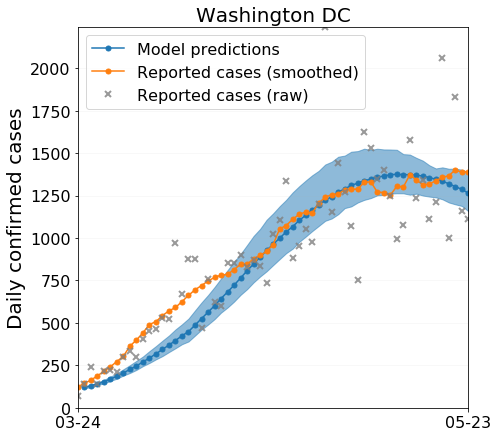

In [14]:
# no mobility model
min_timestring = '2021_01_17_12_40_34_684920'
max_timestring = '2021_01_17_13_13_33_579485'
expected_num_jobs = 280
no_mobility_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                    min_timestring=min_timestring,
                                                    max_timestring=max_timestring, 
                                                    required_properties={'experiment_to_run':'grid_search_no_mobility'})
assert len(no_mobility_df) == expected_num_jobs, len(no_mobility_df)
no_mobility_df['MSA_name'] = no_mobility_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mobility_df['start_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[0])
no_mobility_df['end_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[-1])
no_mobility_df['beta_ratio'] = no_mobility_df.end_beta.values / no_mobility_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mobility_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

Loading models with timestrings between 2021_01_17_08_21_33_262803 and 2021_01_17_10_28_05_182850
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 3.866s -> 0.004s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 15 within loss tol -> keeping 15
Plotting predictions from 15 models
Applying time-varying CDR to visualization


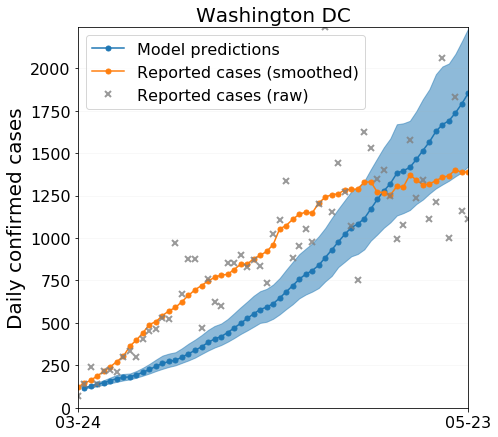

In [16]:
# no mask model
min_timestring = '2021_01_17_08_21_33_262803'
max_timestring = '2021_01_17_10_28_05_182850'
expected_num_jobs = 1050
no_mask_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'grid_search_no_mask_data'})
assert len(no_mask_df) == expected_num_jobs, len(no_mask_df)

no_mask_df['MSA_name'] = no_mask_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mask_df['start_beta'] = no_mask_df['home_beta'].apply(lambda x:x[0])
no_mask_df['end_beta'] = no_mask_df['home_beta'].apply(lambda x:x[-1])
no_mask_df['beta_ratio'] = no_mask_df.end_beta.values / no_mask_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mask_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

Loading models with timestrings between 2021_01_17_11_19_21_297270 and 2021_01_17_12_13_11_582406
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 450 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.399s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 5 within loss tol -> keeping 5
Plotting predictions from 5 models
Applying time-varying CDR to visualization


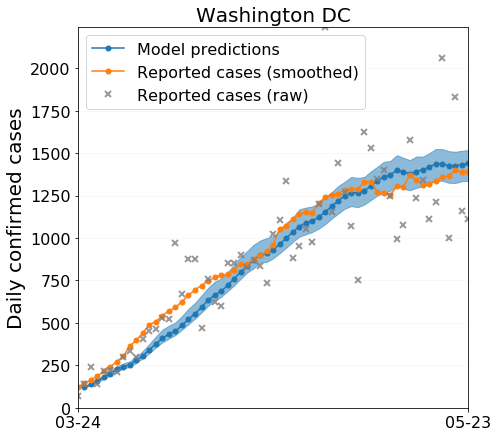

In [17]:
# fixed beta_base over time
min_timestring = '2021_01_17_11_19_21_297270'
max_timestring = '2021_01_17_12_13_11_582406'
expected_num_jobs = 450
fixed_beta_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'grid_search_fixed_beta'})
assert len(fixed_beta_df) == expected_num_jobs, len(fixed_beta_df)
fixed_beta_df['MSA_name'] = fixed_beta_df['data_kwargs'].map(lambda x:x['MSA_name'])
fixed_beta_df['start_beta'] = fixed_beta_df['home_beta']

best_models_df = get_best_models_for_all_msas(fixed_beta_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)

full
Plotting predictions from 5 models
Applying time-varying CDR to visualization
Plotting predictions from 6 models
Applying time-varying CDR to visualization
no mobility
Plotting predictions from 3 models
Applying time-varying CDR to visualization
Plotting predictions from 5 models
Applying time-varying CDR to visualization
no mask
Plotting predictions from 15 models
Applying time-varying CDR to visualization
Plotting predictions from 10 models
Applying time-varying CDR to visualization
fixed beta


/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Plotting predictions from 5 models
Applying time-varying CDR to visualization
Plotting predictions from 3 models
Applying time-varying CDR to visualization


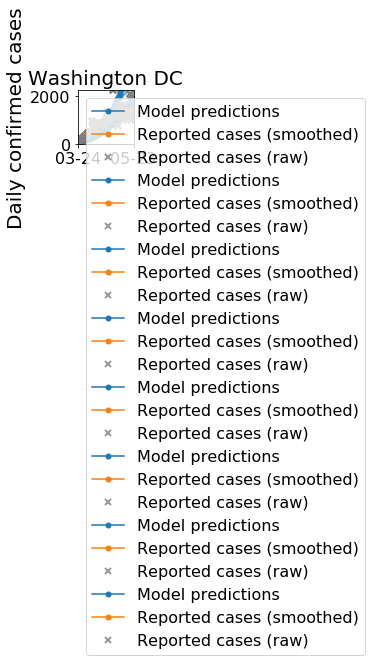

In [18]:
full_loss_key = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
train_loss_key = 'train_' + full_loss_key
test_loss_key = 'test_' + full_loss_key
loss_tol = 1.2
fig, ax = plt.subplots(figsize=(1,1))
all_results = []
for label, df in [('full', gridsearch_df), ('no mobility', no_mobility_df), 
                  ('no mask', no_mask_df), ('fixed beta', fixed_beta_df), ]:
    print(label)
    results = {'model':label}
    # sort by full loss, eval full loss
    best_models_df = get_best_models_for_all_msas(df, full_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=full_loss_key)
    results['full_loss_n_models'] = len(best_models_df)
    params = ['poi_psi', 'start_beta', 'beta_ratio']
    means = msa_best_models.mean()[params]
    mins = msa_best_models.min()[params]
    maxes = msa_best_models.max()[params]
    for p in params:
        results[p] = '%.3f (%.3f-%.3f)' % (means[p], mins[p], maxes[p])
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data)
    results['full_loss_of_mean'] = rmse_of_mean
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data, normalized=True)
    results['normalized_full_loss_of_mean'] = rmse_of_mean

    # sort by train loss, eval test loss
    best_models_df = get_best_models_for_all_msas(df, train_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=train_loss_key)
    results['train_loss_n_models'] = len(msa_best_models)
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                         score_dict['real_dates'], real_data,
                                         train_test_partition=datetime.datetime(2020, 5, 1))
    results['test_loss_of_mean'] = rmse_of_mean
    all_results.append(results)

In [19]:
cols = list(all_results[-1].keys())
first_wave_df = pd.DataFrame(all_results, columns=cols)
first_wave_df.round(3)

,model,full_loss_n_models,poi_psi,start_beta,beta_ratio,full_loss_of_mean,normalized_full_loss_of_mean,train_loss_n_models,test_loss_of_mean
0,full,5,4803.168 (3051.755-6204.298),0.015 (0.011-0.019),0.860 (0.800-1.000),63.607,0.069,6,57.545
1,no mobility,3,0.000 (0.000-0.000),0.025 (0.023-0.026),0.800 (0.700-0.900),105.462,0.114,5,112.879
2,no mask,15,3939.138 (1300.343-6204.298),0.011 (0.006-0.016),0.747 (0.700-0.900),283.071,0.306,10,1270.573
3,fixed beta,5,4943.281 (4102.603-6204.298),0.014 (0.011-0.015),nan (nan-nan),83.133,0.090,3,152.515


## Washington DC, second wave (Table 2, Figure 4, Table A2)

In [20]:
msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 11, 1)
max_datetime = datetime.datetime(2020, 12, 31)

Loading models with timestrings between 2021_01_19_10_48_52_008132 and 2021_01_19_17_02_36_029096
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 3.557s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 7 within loss tol -> keeping 7
Plotting predictions from 7 models
Applying time-varying CDR to visualization


(900, 3439.0)

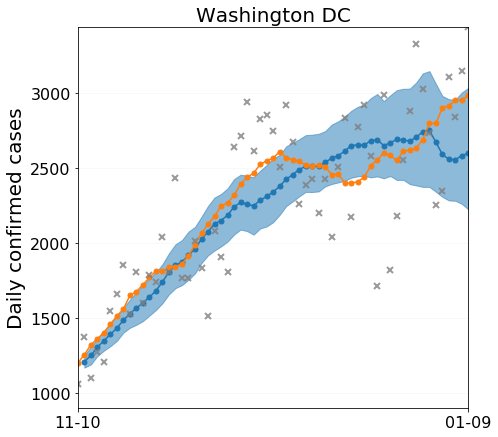

In [21]:
# full model
min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_01_19_17_02_36_029096'
expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
gridsearch_df['start_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[0])
gridsearch_df['end_beta'] = gridsearch_df['home_beta'].apply(lambda x:x[-1])
gridsearch_df['beta_ratio'] = gridsearch_df.end_beta.values / gridsearch_df.start_beta.values

best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

Loading models with timestrings between 2021_01_19_19_59_26_267351 and 2021_01_19_23_32_59_814482
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 280 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.582s -> 0.006s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 2 within loss tol -> keeping 2
Plotting predictions from 2 models
Applying time-varying CDR to visualization


(900, 3439.0)

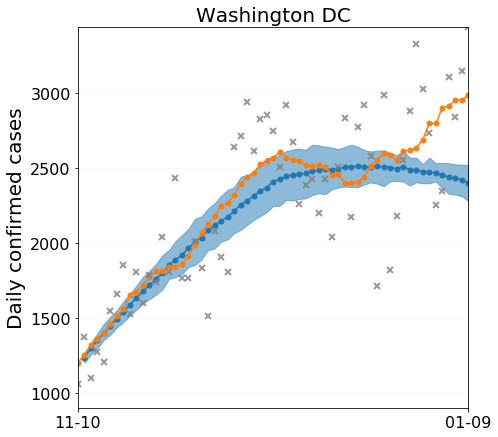

In [22]:
# no mobility model
min_timestring = '2021_01_19_19_59_26_267351'
max_timestring = '2021_01_19_23_32_59_814482'
expected_num_jobs = 280
no_mobility_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'grid_search_no_mobility'})
assert len(no_mobility_df) == expected_num_jobs, len(no_mobility_df)
no_mobility_df['MSA_name'] = no_mobility_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mobility_df['start_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[0])
no_mobility_df['end_beta'] = no_mobility_df['home_beta'].apply(lambda x:x[-1])
no_mobility_df['beta_ratio'] = no_mobility_df.end_beta.values / no_mobility_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mobility_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

Loading models with timestrings between 2021_01_19_19_59_26_267351 and 2021_01_19_22_05_45_370495
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 3.466s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(900, 3439.0)

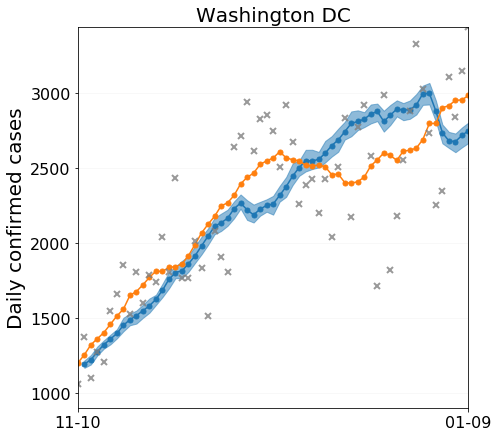

In [23]:
# no mask model
min_timestring = '2021_01_19_19_59_26_267351'
max_timestring = '2021_01_19_22_05_45_370495'
expected_num_jobs = 1050
no_mask_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'grid_search_no_mask_data'})
assert len(no_mask_df) == expected_num_jobs, len(no_mask_df)
no_mask_df['MSA_name'] = no_mask_df['data_kwargs'].map(lambda x:x['MSA_name'])
no_mask_df['start_beta'] = no_mask_df['home_beta'].apply(lambda x:x[0])
no_mask_df['end_beta'] = no_mask_df['home_beta'].apply(lambda x:x[-1])
no_mask_df['beta_ratio'] = no_mask_df.end_beta.values / no_mask_df.start_beta.values

best_models_df = get_best_models_for_all_msas(no_mask_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

Loading models with timestrings between 2021_01_19_19_59_26_267351 and 2021_01_21_22_39_41_407608
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 450 fitted models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Time to load and score all models: 1.519s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Washington_Arlington_Alexandria_DC_VA_MD_WV: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(900, 3439.0)

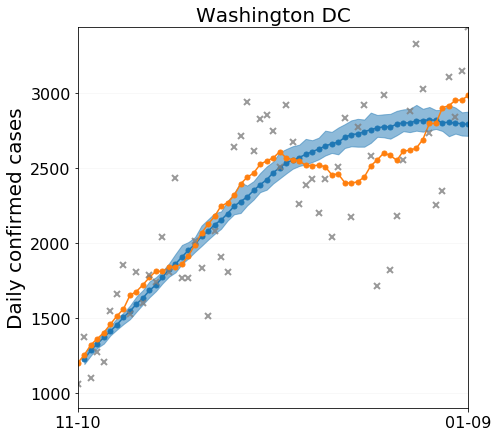

In [24]:
# fixed beta over time
min_timestring = '2021_01_19_19_59_26_267351'
max_timestring = '2021_01_21_22_39_41_407608'
expected_num_jobs = 450
fixed_beta_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'grid_search_fixed_beta'})
assert len(fixed_beta_df) == expected_num_jobs, len(fixed_beta_df)
fixed_beta_df['MSA_name'] = fixed_beta_df['data_kwargs'].map(lambda x:x['MSA_name'])
fixed_beta_df['start_beta'] = fixed_beta_df['home_beta']

best_models_df = get_best_models_for_all_msas(fixed_beta_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(900, ymax)

full
Plotting predictions from 7 models
Applying time-varying CDR to visualization
Plotting predictions from 2 models
Applying time-varying CDR to visualization
no mobility
Plotting predictions from 2 models
Applying time-varying CDR to visualization
Plotting predictions from 1 models
Applying time-varying CDR to visualization
no mask
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 2 models
Applying time-varying CDR to visualization
fixed beta
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 3 models
Applying time-varying CDR to visualization


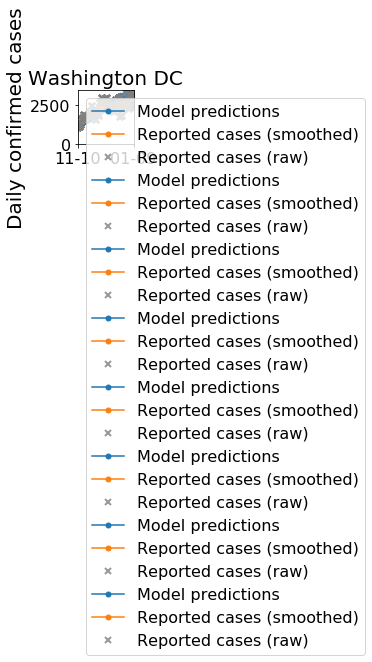

In [25]:
full_loss_key = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
train_loss_key = 'train_' + full_loss_key
test_loss_key = 'test_' + full_loss_key
loss_tol = 1.2
fig, ax = plt.subplots(figsize=(1,1))
all_results = []
for label, df in [('full', gridsearch_df), ('no mobility', no_mobility_df), 
                  ('no mask', no_mask_df), ('fixed beta', fixed_beta_df), ]:
    print(label)
    results = {'model':label}
    # sort by full loss, eval full loss
    best_models_df = get_best_models_for_all_msas(df, full_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=full_loss_key)
    results['full_loss_n_models'] = len(best_models_df)
    params = ['poi_psi', 'start_beta', 'beta_ratio']
    means = msa_best_models.mean()[params]
    mins = msa_best_models.min()[params]
    maxes = msa_best_models.max()[params]
    for p in params:
        results[p] = '%.3f (%.3f-%.3f)' % (means[p], mins[p], maxes[p])
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data)
    results['full_loss_of_mean'] = rmse_of_mean
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data, normalized=True)
    results['normalized_full_loss_of_mean'] = rmse_of_mean

    # sort by train loss, eval test loss
    best_models_df = get_best_models_for_all_msas(df, train_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=train_loss_key)
    results['train_loss_n_models'] = len(msa_best_models)
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                         score_dict['real_dates'], real_data,
                                         train_test_partition=datetime.datetime(2020, 12, 18))
    results['test_loss_of_mean'] = rmse_of_mean
    all_results.append(results)

In [26]:
cols = list(all_results[-1].keys())
second_wave_df = pd.DataFrame(all_results, columns=cols)
second_wave_df.round(3)

,model,full_loss_n_models,poi_psi,start_beta,beta_ratio,full_loss_of_mean,normalized_full_loss_of_mean,train_loss_n_models,test_loss_of_mean
0,full,7,5415.976 (628.315-10403.123),0.029 (0.015-0.045),1.043 (0.900-1.300),158.535,0.070,2,276.636
1,no mobility,2,0.000 (0.000-0.000),0.044 (0.043-0.045),0.950 (0.900-1.000),181.968,0.080,1,299.640
2,no mask,1,3421.117 (3421.117-3421.117),0.009 (0.009-0.009),0.900 (0.900-0.900),209.500,0.092,2,404.530
3,fixed beta,1,628.315 (628.315-628.315),0.043 (0.043-0.043),nan (nan-nan),139.311,0.061,3,257.198


## Richmond and Eastern, second wave (Table 2, Figure 3)

Loading models with timestrings between 2021_01_19_10_48_52_008132 and 2021_01_19_17_02_36_029096
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Richmond_VA
Time to load and score all models: 3.966s -> 0.004s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Richmond_VA: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(80, 816.0)

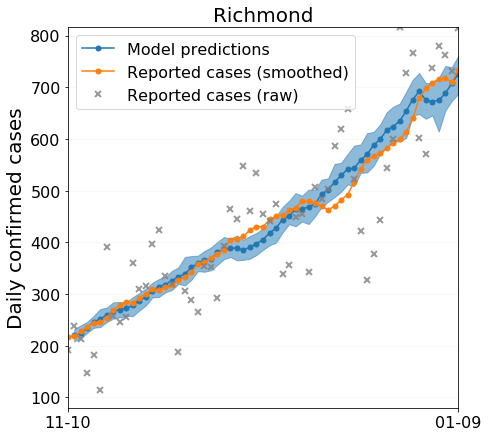

In [27]:
msa_name = 'Richmond_VA'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 11, 1)
max_datetime = datetime.datetime(2020, 12, 31)

min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_01_19_17_02_36_029096'
expected_num_jobs = 1050
richmond_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                 min_timestring=min_timestring,
                                                 max_timestring=max_timestring, 
                                                 required_properties={'experiment_to_run':'normal_grid_search'})
assert len(richmond_df) == expected_num_jobs, len(richmond_df)
richmond_df['MSA_name'] = richmond_df['data_kwargs'].map(lambda x:x['MSA_name'])
richmond_df['start_beta'] = richmond_df['home_beta'].apply(lambda x:x[0])
richmond_df['end_beta'] = richmond_df['home_beta'].apply(lambda x:x[-1])
richmond_df['beta_ratio'] = richmond_df.end_beta.values / richmond_df.start_beta.values

best_models_df = get_best_models_for_all_msas(richmond_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
ymin, ymax = ax.get_ylim()
ax.set_ylim(80, ymax)

Loading models with timestrings between 2021_01_19_10_48_52_008132 and 2021_01_19_17_02_36_029096
144719 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 1050 fitted models for Virginia_Beach_Norfolk_Newport_News_VA_NC
Time to load and score all models: 3.270s -> 0.003s per model
Finding best fit models based on key=loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr, loss tolerance=1.200
Virginia_Beach_Norfolk_Newport_News_VA_NC: 1 within loss tol -> keeping 1
Plotting predictions from 1 models
Applying time-varying CDR to visualization


(80, 1297.0)

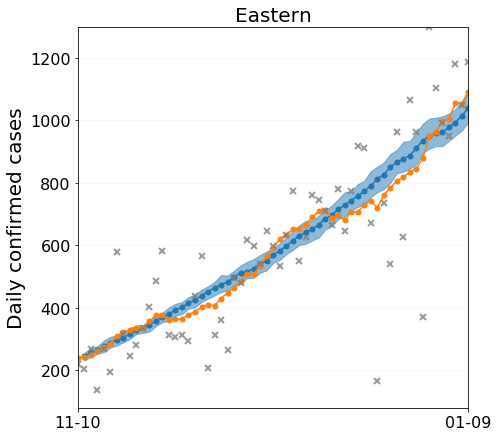

In [28]:
msa_name = 'Virginia_Beach_Norfolk_Newport_News_VA_NC'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
min_datetime = datetime.datetime(2020, 11, 1)
max_datetime = datetime.datetime(2020, 12, 31)

min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_01_19_17_02_36_029096'
expected_num_jobs = 1050
eastern_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring, 
                                                required_properties={'experiment_to_run':'normal_grid_search'})
assert len(eastern_df) == expected_num_jobs, len(eastern_df)
eastern_df['MSA_name'] = eastern_df['data_kwargs'].map(lambda x:x['MSA_name'])
eastern_df['start_beta'] = eastern_df['home_beta'].apply(lambda x:x[0])
eastern_df['end_beta'] = eastern_df['home_beta'].apply(lambda x:x[-1])
eastern_df['beta_ratio'] = eastern_df.end_beta.values / eastern_df.start_beta.values

best_models_df = get_best_models_for_all_msas(eastern_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
best_models_df = best_models_df.sort_values(by=key_to_sort_by)
fig, ax = plt.subplots(figsize=(7,7))
out = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime, additional_kwargs={'plot_legend':False})
ymin, ymax = ax.get_ylim()
ax.set_ylim(80, ymax)

Richmond_VA
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 2 models
Applying time-varying CDR to visualization
Virginia_Beach_Norfolk_Newport_News_VA_NC
Plotting predictions from 1 models
Applying time-varying CDR to visualization
Plotting predictions from 1 models
Applying time-varying CDR to visualization


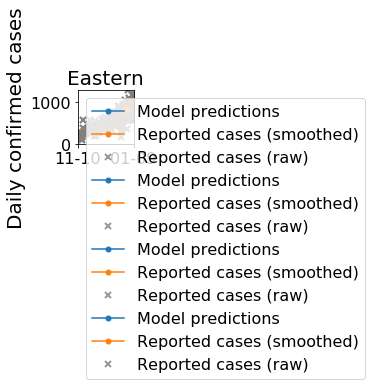

In [29]:
full_loss_key = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'
train_loss_key = 'train_' + full_loss_key
test_loss_key = 'test_' + full_loss_key
loss_tol = 1.2
fig, ax = plt.subplots(figsize=(1,1))
all_results = []
for msa_name, df in [('Richmond_VA', richmond_df), ('Virginia_Beach_Norfolk_Newport_News_VA_NC', eastern_df)]:
    print(msa_name)
    results = {'msa':MSAS_TO_PRETTY_NAMES[msa_name]}
    # sort by full loss, eval full loss
    best_models_df = get_best_models_for_all_msas(df, full_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=full_loss_key)
    results['full_loss_n_models'] = len(best_models_df)
    params = ['poi_psi', 'start_beta', 'beta_ratio']
    means = msa_best_models.mean()[params]
    mins = msa_best_models.min()[params]
    maxes = msa_best_models.max()[params]
    for p in params:
        results[p] = '%.3f (%.3f-%.3f)' % (means[p], mins[p], maxes[p])
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data)
    results['full_loss_of_mean'] = rmse_of_mean
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                     score_dict['real_dates'], real_data, normalized=True)
    results['normalized_full_loss_of_mean'] = rmse_of_mean

    # sort by train loss, eval test loss
    best_models_df = get_best_models_for_all_msas(df, train_loss_key, loss_tolerance=loss_tol, verbose=False)
    msa_best_models = best_models_df.sort_values(by=train_loss_key)
    results['train_loss_n_models'] = len(msa_best_models)
    score_dict = plot_model_fit_for_msa(best_models_df, msa_name, ax, min_datetime, max_datetime)
    real_data = score_dict['smoothed_real_data']
    _, rmse_of_mean = compute_rmses(score_dict['pred_dates'], score_dict['pred_data'], 
                                         score_dict['real_dates'], real_data,
                                         train_test_partition=datetime.datetime(2020, 12, 18))
    results['test_loss_of_mean'] = rmse_of_mean
    all_results.append(results)

In [30]:
cols = list(all_results[-1].keys())
second_wave_df = pd.DataFrame(all_results, columns=cols)
second_wave_df.round(3)

,msa,full_loss_n_models,poi_psi,start_beta,beta_ratio,full_loss_of_mean,normalized_full_loss_of_mean,train_loss_n_models,test_loss_of_mean
0,Richmond,1,3421.117 (3421.117-3421.117),0.027 (0.027-0.027),1.300 (1.300-1.300),21.930,0.049,2,53.272
1,Eastern,1,2024.716 (2024.716-2024.716),0.033 (0.033-0.033),1.200 (1.200-1.200),37.391,0.063,1,49.394


# 3. Use cases

## SES disparities over time (Figure 5)

In [264]:
# msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'
msa_name = 'Columbia_SC'
key_to_sort_by = 'loss_dict_smoothed_daily_cases_RMSE_time_varying_cdr'

min_timestring = '2021_01_16_15_27_26_107791'
max_timestring = '2021_11_16_17_36_28_098096'
expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
first_wave_models = best_models_df.sort_values(by=key_to_sort_by)

min_timestring = '2021_01_19_10_48_52_008132'
max_timestring = '2021_11_19_17_02_36_029096'
expected_num_jobs = 1050
gridsearch_df = evaluate_all_fitted_models_for_msa(msa_name,
                                                   min_timestring=min_timestring,
                                                   max_timestring=max_timestring, 
                                                   required_properties={'experiment_to_run':'normal_grid_search'})
assert len(gridsearch_df) == expected_num_jobs, len(gridsearch_df)
gridsearch_df['MSA_name'] = gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])
best_models_df = get_best_models_for_all_msas(gridsearch_df, key_to_sort_by, loss_tolerance=1.2, verbose=True)
second_wave_models = best_models_df.sort_values(by=key_to_sort_by)

Loading models with timestrings between 2021_01_16_15_27_26_107791 and 2021_11_16_17_36_28_098096
4213 files in directory /media/gpu/Seagate/extra_safegraph_aggregate_models/data_and_model_configs
Found 0 fitted models for Columbia_SC


ZeroDivisionError: float division by zero

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

ax = axes[0]
mean = plot_lir_over_time_for_multiple_models(first_wave_models.timestring.values, ax, 'bottom income decile', 'darkorchid', group='median_household_income_bottom_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(first_wave_models.timestring.values, ax, 'top income decile', 'darkgoldenrod', group='median_household_income_top_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(first_wave_models.timestring.values, ax, 'overall', 'tab:blue', group='all')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.SU, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.legend(fontsize=16)
ax.grid(alpha=0.3)
ax.set_ylabel('Cumulative infections (per 100k pop)', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title('Washington DC, first wave', fontsize=18)

ax = axes[1]
mean = plot_lir_over_time_for_multiple_models(second_wave_models.timestring.values, ax, 'bottom income decile', 'darkorchid', group='median_household_income_bottom_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(second_wave_models.timestring.values, ax, 'top income decile', 'darkgoldenrod', group='median_household_income_top_decile')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
mean = plot_lir_over_time_for_multiple_models(second_wave_models.timestring.values, ax, 'overall', 'tab:blue', group='all')
print('Diff = %.2f; ratio = %.2f' % (mean[-1] - mean[0], mean[-1] / mean[0]))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.SU, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.grid(alpha=0.3)
ax.set_xlabel('Date', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title('Washington DC, second wave', fontsize=18)

Num params x seeds: 90
Diff = 4568.88; ratio = 1.51
Num params x seeds: 90
Diff = 7139.36; ratio = 1.78
Num params x seeds: 90
Diff = 5380.33; ratio = 1.59
Num params x seeds: 90
Diff = 4568.88; ratio = 1.51
Num params x seeds: 90
Diff = 7139.36; ratio = 1.78
Num params x seeds: 90
Diff = 5380.33; ratio = 1.59


Text(0.5, 1.0, 'Washington DC, second wave')

## Opening POI categories to different degrees (dashboard data)

In [9]:
model_timestrings, model_msas = filter_timestrings_for_properties(
            min_timestring='2021_01_29_10_08_16_729086',
            max_timestring='2021_12_01_01_02_55_384518',
            return_msa_names=True)
print('Found %d timestrings' % len(model_timestrings))
print(max(model_timestrings))
print(Counter(model_msas))

Loading models with timestrings between 2021_01_29_10_08_16_729086 and 2021_12_01_01_02_55_384518
1266 files in directory /media/gpu/easystore/extra_safegraph_aggregate_models/data_and_model_configs
Found 1266 timestrings
2021_10_30_15_33_31_426462_normal_grid_search_normal_grid_search
Counter({'Columbia_SC': 1266})


In [10]:
# aggregate results over stochastic realizations per opening configuration
path_to_results = os.path.join(helper.FITTED_MODEL_DIR, 'model_results')
config2results = {}
groups = list(CATEGORY_GROUPS.keys())
for i, (msa_name, ts) in enumerate(zip(model_msas, model_timestrings)):
    if i % 1000 == 0:
        print(i)
    file = open(os.path.join(path_to_results, 'dashboard_results_%s.pkl' % ts), 'rb')
    config, num_visits, infection_results = pickle.load(file)
    file.close()
    config_key = [msa_name]
    for g in groups:
        first_cat = CATEGORY_GROUPS[g][0]
        if first_cat in config:
            config_key.append(int(config[first_cat] * 100))
        else:
            config_key.append(-1)
    config_key = tuple(config_key)
    
    if config_key not in config2results:
        results = {}
        results['num_visits'] = num_visits
        for week in range(1, 5):
            results['infections_week%d' % week] = []
        config2results[config_key] = results
    else:
        assert np.isclose(config2results[config_key]['num_visits'], num_visits)
    for week in range(1, 5):
        config2results[config_key]['infections_week%d' % week].extend(list(infection_results[week]))

0


FileNotFoundError: [Errno 2] No such file or directory: '/media/gpu/easystore/extra_safegraph_aggregate_models/model_results/dashboard_results_2021_10_29_22_58_29_598220_calibrate_r0_calibrate_r0.pkl'

In [11]:
all_results_for_df = []
sorted_configs = sorted(config2results.keys())
for config in sorted_configs:
    results = config2results[config]
    assert len(config) == (len(groups)+1)
    results_for_df = {}
    results_for_df['msa'] = config[0]
    for g, setting in zip(groups, config[1:]):
        results_for_df['_'.join(g.lower().split())] = setting
    results_for_df['intervention_date'] = '2021-01-01'
    results_for_df['total_visits_post_intervention_in_millions'] = round(results['num_visits'] / 1000000, 2)
    for week in range(1, 5):
        vector = results['infections_week%d' % week]
        results_for_df['infections_week%d_mean' % week] = int(round(np.mean(vector), 0))
        results_for_df['infections_week%d_CI_lower' % week] = int(round(np.percentile(vector, 2.5), 0))
        results_for_df['infections_week%d_CI_upper' % week] = int(round(np.percentile(vector, 97.5), 0))
    all_results_for_df.append(results_for_df)
    
cols = list(all_results_for_df[0].keys())
infections_df = pd.DataFrame(all_results_for_df, columns=cols)
infections_df.head()

IndexError: list index out of range

# Show a full fitted model

In [172]:
fitted_model.__dict__.keys()

dict_keys(['starting_seed', 'num_seeds', 'debug', 'ipf_final_match', 'ipf_num_iter', 'clip_poisson_approximation', 'M', 'N', 'T', 'POI_TIME_COUNTS', 'POI_CBG_PROPORTIONS', 'PSI', 'POI_AREAS', 'DWELL_TIME_CORRECTION_FACTORS', 'POI_FACTORS', 'POI_SUBCATEGORY_TYPES', 'included_dwell_time_correction_factors', 'POI_CBG_VISITS_LIST', 'CBG_SIZES', 'cbg_day_prop_out', 'HOME_BETA', 'inter_cbg_travel', 'GAMMA', 'cbg_idx_groups_to_track', 'cbg_idx_to_seed_in', 'ALL_UNIQUE_CBGS', 'CBGS_TO_IDXS', 'LATENCY_PERIOD', 'INFECTIOUS_PERIOD', 'ALL_STATES', 'all_hours', 'P_SICK_AT_T0', 'initial_conditions', 'just_compute_r0', 'INTERVENTION_COST', 'track_full_history_for_all_CBGs', 'confirmation_rate', 'confirmation_lag', 'death_rate', 'death_lag', 'daily_mask_use', 'mask_efficacy', 'cbg_latent', 'cbg_infected', 'cbg_removed', 'cases_to_confirm', 'new_confirmed_cases', 'deaths_to_happen', 'new_deaths', 'full_history_for_all_CBGs', 'clipping_monitor', 'history', 'poi_cbg_visit_history', 'estimated_R0', 'do_ip

In [335]:
fitted_model.__dict__['POI_FACTORS']

# do not stored.

In [173]:
dir(fitted_model)

['ALL_STATES',
 'ALL_UNIQUE_CBGS',
 'CBGS_TO_IDXS',
 'CBG_SIZES',
 'DWELL_TIME_CORRECTION_FACTORS',
 'GAMMA',
 'HOME_BETA',
 'INFECTIOUS_PERIOD',
 'INTERVENTION_COST',
 'LATENCY_PERIOD',
 'M',
 'N',
 'POI_AREAS',
 'POI_CBG_PROPORTIONS',
 'POI_CBG_VISITS_LIST',
 'POI_FACTORS',
 'POI_SUBCATEGORY_TYPES',
 'POI_TIME_COUNTS',
 'PSI',
 'P_SICK_AT_T0',
 'T',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_proportions_matrix',
 'all_hours',
 'cases_to_confirm',
 'cbg_day_prop_out',
 'cbg_idx_groups_to_track',
 'cbg_idx_to_seed_in',
 'cbg_infected',
 'cbg_latent',
 'cbg_new_cases',
 'cbg_new_cases_from_base',
 'cbg_new_cases_from_poi',
 'cbg_num_out',
 'cbg_removed',
 '

In [180]:

import json
import pickle

# pkl = r'/media/gpu/easystore/extra_safegraph_aggregate_models/full_models/fitted_model_2021_10_06_15_38_48_687729.pkl'
pkl = r'/media/gpu/Seagate/extra_safegraph_aggregate_models/full_models/fitted_model_2021_11_27_20_12_56_761158_normal_grid_search_normal_grid_search.pkl'

fitted_model = pickle.load(open(pkl, 'rb'))

model_results_to_save_separately = {}
for attr_to_save_separately in [ 'cbg_new_cases_from_poi']:  # 'history',
    model_results_to_save_separately[attr_to_save_separately] = getattr(fitted_model, attr_to_save_separately)
    print(getattr(fitted_model, attr_to_save_separately))

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [197]:
fitted_model.__dict__['deaths_to_happen'].mean(axis=0)

array([1.43333333, 0.66666667, 0.63333333, 0.43333333, 0.96666667,
       0.53333333, 0.5       , 0.76666667, 0.53333333, 0.43333333,
       0.43333333, 0.1       , 0.2       , 0.        , 0.13333333,
       0.16666667, 0.3       , 0.23333333, 0.16666667, 0.33333333,
       0.33333333, 0.1       , 0.16666667, 0.36666667, 0.4       ,
       0.56666667, 0.33333333, 0.33333333, 0.13333333, 0.26666667,
       0.23333333, 0.13333333, 0.36666667, 0.43333333, 0.33333333,
       0.2       , 0.16666667, 0.2       , 0.5       , 0.13333333,
       0.1       , 0.        , 0.03333333, 0.16666667, 0.3       ,
       0.23333333, 0.16666667, 0.23333333, 0.06666667, 0.13333333,
       0.23333333, 0.26666667, 0.46666667, 0.66666667, 0.4       ,
       0.66666667, 0.46666667, 0.03333333, 0.1       , 0.06666667,
       0.03333333, 0.16666667, 0.06666667, 0.06666667, 0.06666667,
       0.1       , 0.2       , 0.23333333, 0.1       , 0.1       ,
       0.23333333, 0.13333333, 0.26666667, 0.4       , 0.16666